<a href="https://colab.research.google.com/github/geporys/ts-project-assignment-hse-2023/blob/main/ExportForecastLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
sys.path.append("/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/functions")

In [2]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from functions.data import get_NIC_from_yFinance, get_nickel_data_from_businessinsider, get_rates, union_data_in_one_df
from functions.chart import plot_nick_rate_nic
from functions.model import first_model


In [3]:
nic_df = get_NIC_from_yFinance()

In [4]:
nic_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-20 00:00:00+10:00,0.270224,0.270224,0.234194,0.252209,14621347,0.0,0.0
2018-08-21 00:00:00+10:00,0.252209,0.256713,0.225187,0.229690,2166061,0.0,0.0
2018-08-22 00:00:00+10:00,0.238698,0.265720,0.234194,0.261217,6654300,0.0,0.0
2018-08-23 00:00:00+10:00,0.274728,0.279231,0.270224,0.270224,3775078,0.0,0.0
2018-08-24 00:00:00+10:00,0.274728,0.274728,0.265720,0.274728,3203045,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-26 00:00:00+11:00,0.956068,0.960971,0.931553,0.956068,21232381,0.0,0.0
2022-12-27 00:00:00+11:00,0.956068,0.960971,0.931553,0.956068,21232381,0.0,0.0
2022-12-28 00:00:00+11:00,0.951165,0.951165,0.931553,0.941359,1920142,0.0,0.0


In [5]:
(nic_df, nickel_df) = get_nickel_data_from_businessinsider(nic_df)

In [6]:
rates = get_rates(nic_df)

In [7]:
ind_exp = pd.read_excel("forecasting_ts_project_raw_data/TABEL5_14_volume by sector.xls", sheet_name='5.14', header=4)

In [8]:
ind_exp = ind_exp.transpose().reset_index()

In [9]:
ind_exp_cols = ['Year', 'Month'] + list(ind_exp.iloc[176][2:69]) + ['drop1', 'drop2']
ind_exp.columns = ind_exp_cols

In [10]:
ind_exp = ind_exp[3:174].drop(columns=['drop1', 'drop2'])

In [11]:
bo = ~ind_exp['Year'].str.contains('Unnamed').fillna(False)
ind_exp['Year'] = ind_exp['Year'].where(bo).fillna(method='ffill')

In [12]:
ind_exp = ind_exp[~ind_exp['Month'].isna()]

In [13]:
ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_61256/3288374492.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')


In [14]:
ind_exp['Day'] = 1
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
ind_exp.replace({'Month': months}, inplace=True)

In [15]:
dt = pd.to_datetime(ind_exp[['Year', 'Month', 'Day']], format="%Y%m%d")
ind_exp['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in dt]

In [16]:
ind_exp.set_index('Date', inplace=True)
ind_exp = ind_exp.asfreq(freq='m', method='ffill').fillna(method='ffill')

In [17]:
ind_exp = ind_exp[['Base metal products', 'Nickel ore']]

# Slice period 
ind_exp = ind_exp['2018-09-30':]

In [25]:
mining = pd.DataFrame(data=[
    {'date': '2018-07-01', 'value': 36933},
    {'date': '2018-08-01', 'value': 40904},
    {'date': '2018-09-01', 'value': 48155},
    {'date': '2018-10-01', 'value': 40579},
    {'date': '2018-11-01', 'value': 43322},
    {'date': '2018-12-01', 'value': 39275},
    {'date': '2019-01-01', 'value': 39848},
    {'date': '2019-02-01', 'value': 42772},
    {'date': '2019-03-01', 'value': 44576},
    {'date': '2019-04-01', 'value': 20509},
    {'date': '2019-05-01', 'value': 33281},
    {'date': '2019-06-01', 'value': 24461},
    {'date': '2019-07-01', 'value': 57000},
    {'date': '2019-08-01', 'value': 64000},
    {'date': '2019-09-01', 'value': 77950},
    {'date': '2019-10-01', 'value': 69734},
    {'date': '2019-11-01', 'value': 56086},
    {'date': '2019-12-01', 'value': 68339},
    {'date': '2020-01-01', 'value': 50600},
    {'date': '2020-02-01', 'value': 49666},
    {'date': '2020-03-01', 'value': 49643},
    {'date': '2020-04-01', 'value': 12500},
    {'date': '2020-05-01', 'value': 25400},
    {'date': '2020-06-01', 'value': 24600},
    {'date': '2020-07-01', 'value': 9500},
    {'date': '2020-08-01', 'value': 45900},
    {'date': '2020-09-01', 'value': 102800},
    {'date': '2020-10-01', 'value': 174193},
    {'date': '2020-11-01', 'value': 173930},
    {'date': '2020-12-01', 'value': 151764},
    {'date': '2021-01-01', 'value': 156039},
    {'date': '2021-02-01', 'value': 117728},
    {'date': '2021-03-01', 'value': 182720},
    {'date': '2021-04-01', 'value': 196617},
    {'date': '2021-05-01', 'value': 142056},
    {'date': '2021-06-01', 'value': 236118},
    {'date': '2021-07-01', 'value': 166506},
    {'date': '2021-08-01', 'value': 193068},
    {'date': '2021-09-01', 'value': 219582},
    {'date': '2021-10-01', 'value': 250000},
    {'date': '2021-11-01', 'value': 250000},
    {'date': '2021-12-01', 'value': 250000},
    {'date': '2022-01-01', 'value': 283494},
    {'date': '2022-02-01', 'value': 213090},
    {'date': '2022-03-01', 'value': 313740},
    {'date': '2022-04-01', 'value': 792630/3},
    {'date': '2022-05-01', 'value': 792630/3},
    {'date': '2022-06-01', 'value': 792630/3},
    {'date': '2022-07-01', 'value': 599590/3},
    {'date': '2022-08-01', 'value': 599590/3},
    {'date': '2022-09-01', 'value': 599590/3},
    {'date': '2022-10-01', 'value': 339672},
    {'date': '2022-11-01', 'value': 205722},
    {'date': '2022-12-31', 'value': 301866},
])


mining['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in mining['date']]


mining = mining.set_index('date')
mining = mining.asfreq(freq='B').fillna(method='ffill')
mining = mining[mining.index >= nic_df.index[0]]

<AxesSubplot: xlabel='date'>

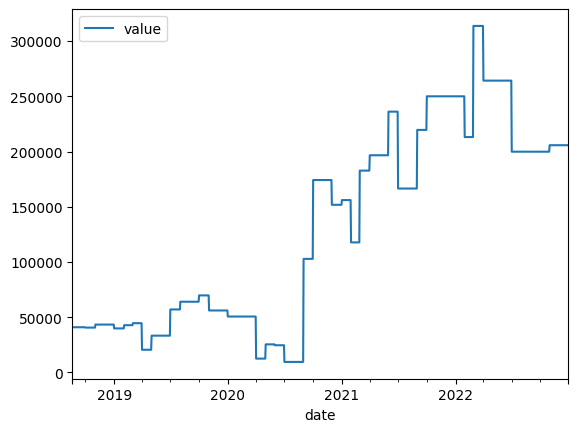

In [27]:
mining.plot()

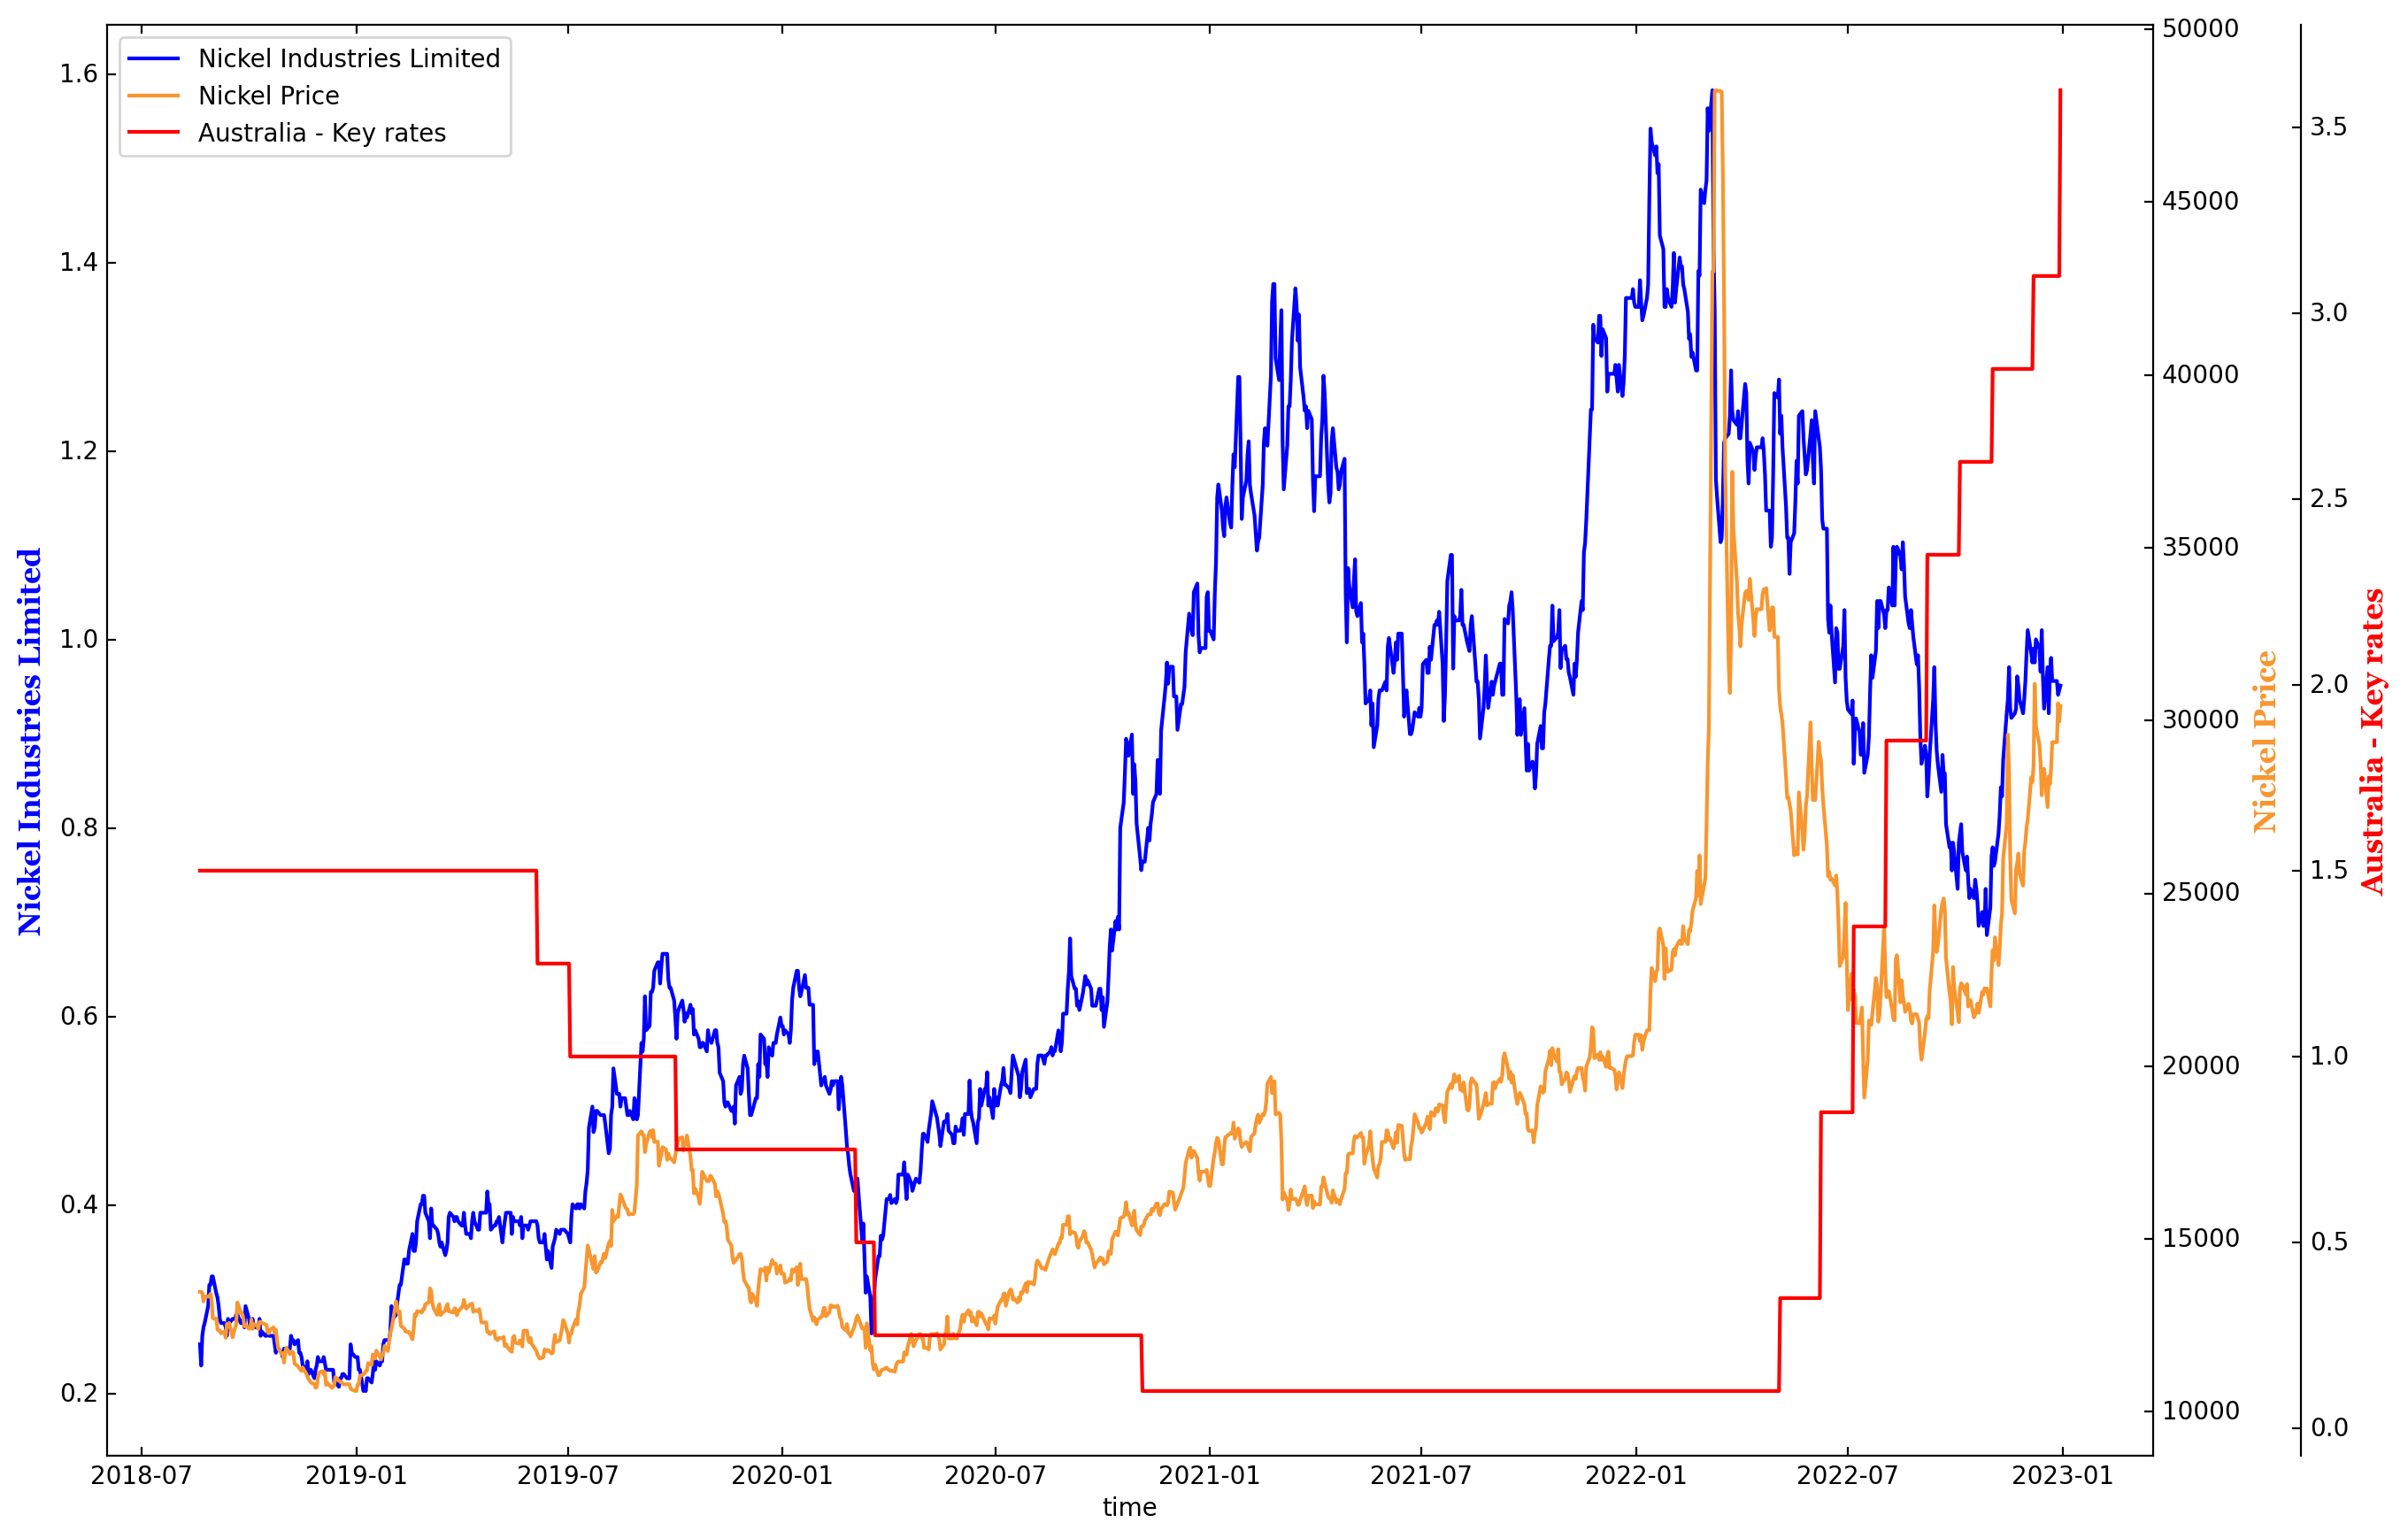

In [21]:
plot_nick_rate_nic(nickel_df, rates, nic_df)

In [22]:
data = union_data_in_one_df(nickel_df, rates, nic_df)


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    NIC   No. Observations:                 1110
Model:                 ARIMA(4, 1, 1)   Log Likelihood                2432.560
Date:                Sat, 25 Mar 2023   AIC                          -4849.120
Time:                        03:08:50   BIC                          -4809.030
Sample:                    08-20-2018   HQIC                         -4833.960
                         - 11-18-2022                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Nickle price  4.858e-06   8.92e-07      5.445      0.000    3.11e-06    6.61e-06
Rate            -0.0445      0.019     -2.298      0.022      -0.082      -0.007
ar.L1            0.0354      0.861      0.04

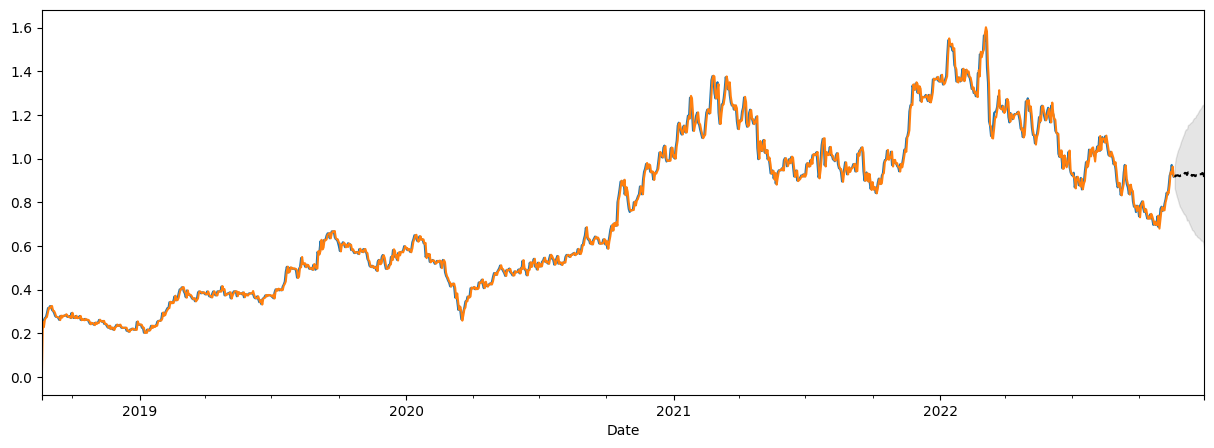

In [23]:
first_model(data)